In [3]:
# import packages 
import os
import datetime
import numpy as np
import matplotlib.pyplot as plt


from sentinelhub import SHConfig
from sentinelhub import MimeType, CRS, BBox, SentinelHubRequest, SentinelHubDownloadClient,DataSource,DownloadRequest
from sentinelhub import bbox_to_dimensions

# Requirements to access satellite imagery

We need to have a free (trial) Sentinel Hub account and then we can create a new OAuth client and use its CLIENT_ID and CLIENT_SECRET to create an instance of sentinelhub.SHConfig. After this is done we can access the data

In [4]:
#OAuth credentials from my Sentinel Hub account
CLIENT_ID = 'b8aa114b-1d45-477d-937f-d91554222c9b'
#CLIENT_SECRET key should be kept hidden so I am not showing it here
CLIENT_SECRET = 'secret-key-value'

In [5]:
#configuration
config = SHConfig()

if CLIENT_ID and CLIENT_SECRET:
    config.sh_client_id = CLIENT_ID
    config.sh_client_secret = CLIENT_SECRET

if config.sh_client_id == '' or config.sh_client_secret == '':
    print("Warning! To use Sentinel Hub services, please provide the credentials (client ID and client secret).")

In [7]:
#pre-defined function used for plotting RGB images
def plot_image(image, factor=1.0, clip_range = None, **kwargs):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])

# Accessing Sentinel-2 for Images

We first find the coordinates for the region we need. This is our area of interest and in my case it is the Sunderbans delta. The WGS64 coordinate system is used and a bounding box is needed to define the scope of the image. The coordinates provided are the bottom left and top right corners of this box. 

In [54]:
#Location Coordinates for Sunderbans National Park found at http://bboxfinder.com/
coords_wgs84 = [88.612170,21.502832,89.046017,21.816675]

In [55]:
#Size of bounding box
resolution = 60
betsiboka_bbox = BBox(bbox=coords_wgs84, crs=CRS.WGS84)
betsiboka_size = bbox_to_dimensions(betsiboka_bbox, resolution = resolution)
print(f'Image shape at {resolution} m resolution: {betsiboka_size} pixels')

Image shape at 60 m resolution: (742, 588) pixels


In [56]:
#pre-defined evalscript for true color images 
#as given for free use at https://github.com/sentinel-hub/custom-scripts#sentinel-2

evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

Here we make the request for the specific time interval. To see what date/time the satellite was above the selected region, one can make a request or go to Sentinel Hub EO Browser (https://apps.sentinel-hub.com/eo-browser/). We pass in the box and size and make the request. The satellite was above this region on 11th October 2020 and 13th October 2020.

In [ ]:

#make request for specific interval from 
request_true_color = SentinelHubRequest(
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_source=DataSource.SENTINEL2_L1C,
            time_interval=('2020-10-11', '2020-10-13'),
        )
    ],
    responses=[
        SentinelHubRequest.output_response('default', MimeType.PNG)
    ],
    bbox=betsiboka_bbox,
    size=betsiboka_size,
    config=config
)

The method get_data() will always return a list of length 1 with the available image from the requested time interval in the form of numpy arrays.

In [57]:
true_color_imgs = request_true_color.get_data()

In [58]:
print(f'Returned data is of type = {type(true_color_imgs)} and length {len(true_color_imgs)}.')
print(f'Single element in the list is of type {type(true_color_imgs[-1])} and has shape {true_color_imgs[-1].shape}')

Returned data is of type = <class 'list'> and length 1.
Single element in the list is of type <class 'numpy.ndarray'> and has shape (588, 742, 3)


We can display the data using the predined plot_image function that Sentinel Hub provides (which can also be imported as a package) here - https://github.com/sentinel-hub/sentinelhub-py/blob/master/examples/utils.py

Image type: uint8


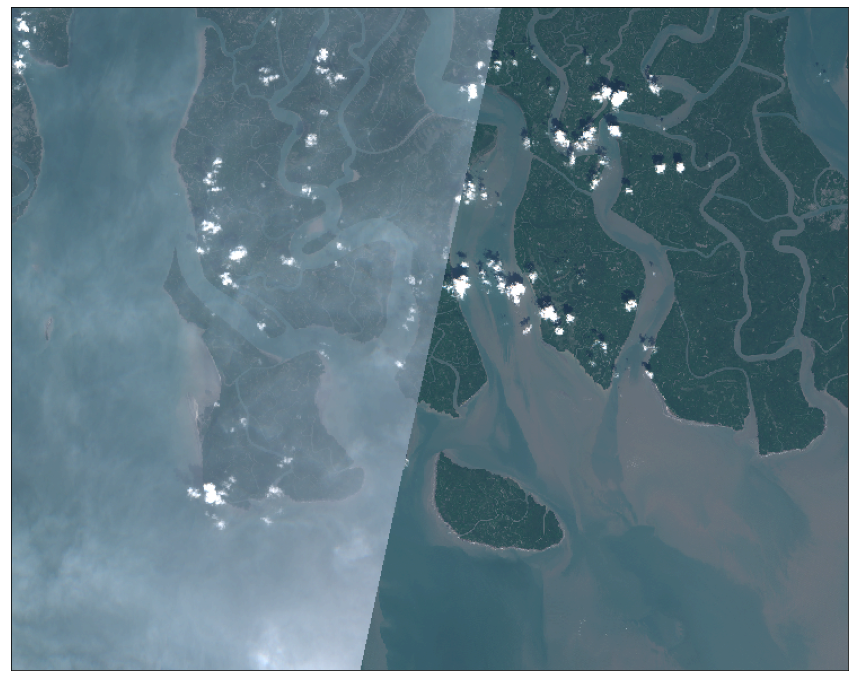

In [59]:
#Displaying the image
image = true_color_imgs[0]
print(f'Image type: {image.dtype}')
plot_image(image, factor=3.5/255, clip_range=(0,1))